In [48]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

import time

In [ ]:
class Circuit:
    def __init__(self,n):
        self.n = n
        self.wires = [Wire(k) for k in range(n)]
        self.gates = []
        
    def addGate(self,g):
        self.gates.append(g)
        for bit in g.bits:
            self.wires[bit].addGate(g)
            
    def appendCircuit(self,circuit, offset=0):
        if offset == 0:
            for gate in circuit.gates:
                self.addGate(gate)
        else:
            pass
    
    def __str__(self):
        string = ""
        for gate in self.gates:
            string = string + str(gate)
            
        return string
        
    def fullStoch(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
        state = state2dist(self.n,state)
        for gate in self.gates:
            state = gate.fullStoch(self.n) @ state
        return state
    
    
    def printWires(self):
        for wire in self.wires:
            print(wire)
            
    def fireShot(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
            
        for gate in self.gates:
            gate_state = [state[b] for b in gate.bits]
            gate_state = gate.fireLocal(gate_state)
            for i in range(len(gate_state)):
                state[gate.bits[i]] = gate_state[i]
        return state
        
    def expectationShots(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        runningtotal = self.fireShot()
        for i in range(numshots-1):
            runningtotal = runningtotal + self.fireShot()
        
        return [x / numshots for x in runningtotal]
    
    def shotsDist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = {}
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                ind += 2**k * state[k] 
            ind = int(ind)
            if ind in histstates:
                histstates[ind] += 1
            else:
                histstates[ind] = 1
        for k in histstates:
            histstates[k] /= numshots
        return histstates
    
    def shotsDistHist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = np.zeros(2**self.n)
        xs = np.zeros(2**self.n)
        
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                 ind += 2**k * state[k] 
            histstates[ind] += 1
            xs[ind] = ind
        hist = plt.bar(xs,histstates)
        return hist
        
class Wire:
    def __init__(self,k):
        self.k = k
        self.gates = []
    
    def addGate(self,g):
        self.gates.append(g)
    
    def removeLastGate(self):
        return self.gates.pop()
    
    def __str__(self):
        string = f"[{self.k}]:"
        for gate in self.gates:
            string += str(gate)
        return string

class Gate:
    #assumes if bits = (0,1,2), order is kron(b2,b1,b0).  This follows from c01 gate having control
    #on 0 and target on 1 by convention
    gatecount = 0

    def __init__(self,matrix,bits):
        assert(matrix.shape == (2**len(bits),2**len(bits)))
        self.matrix = matrix
        self.bits = bits
        self.id = Gate.gatecount
        Gate.gatecount += 1
        
    def __str__(self):
        str = ""
        if len(self.bits) == 1:
            str = f"-a{self.id}"
        else:
            str = f"-b{self.id}"
        return str
    
    
    def fireLocal(self,state):
        #TODO: verify that this is resilient to weird ordered qubits
        state_dist = state2dist(len(state),state)
        new_dist = np.dot(self.matrix,state_dist)
        new_state = sampledist(len(state),new_dist)
        return new_state;
    
    def fullStoch(self,n):
        #TODO: optimize for adjacent bit states (no swaps required)
        #first construct hamiltonian operating on first len(bits) qubits, then swap bits to fit order
        stoch = self.matrix
        for i in range(n - len(self.bits)):
            stoch = np.kron([[1,0],[0,1]],stoch)
            
        swaps = Gate._swapcircuit(self,n)
        if len(swaps):
            stoch = np.dot(stoch, np.transpose(swaps))
            stoch = np.dot(swaps, stoch)
            
        return stoch
    
    def _swapcircuit(self,n):
        swaplist = Gate._bubbleSortOperations(self.bits) 
        sortedbits = sorted(self.bits)
        for i in range(len(sortedbits)-1,-1,-1):
            if not (i == sortedbits[i]):
                swaplist.append((i,sortedbits[i]))
        return Gate._swapStoch(self,n,swaplist)
    
    
    def _swapStoch(self,n,swaplist):
        swapMatrix =  []
        if not (len(swaplist) == 0):
            swapMatrix = np.eye(2**n)
            for swapbits in swaplist:
                swapMatrix = np.dot(Gate._generateSwapMatrix(n,swapbits),swapMatrix)
        return swapMatrix
    
    def _generateSwapMatrix(n,swapbits):
        N = 2**n
        swapMat = np.zeros((N,N))
        for i in range(N):
            mask1 = i >> swapbits[0] & 1
            mask2 = i >> swapbits[1] & 1
            xor = mask1 ^ mask2
            xor = xor << swapbits[0] | xor << swapbits[1]
            j = i ^ xor
            swapMat[i,j] = 1
        return swapMat
    
    def _bubbleSortOperations(bits):
        issorted = False
        swaplist = []
        while not issorted:
            issorted = True
            for i in range(len(bits) - 1):
                if bits[i] > bits[i+1]:
                    temp = bits[i]
                    bits[i] = bits[i+1]
                    bits[i+1] = temp
                    issorted = False
                    swaplist.append((i,i+1))
        return swaplist

def state2dist(n,state):
    ##reverse marginal calculation, assuming no correlation
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #simialr to a bit string
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    dist = np.zeros(2**n)
    for i in range(2**n):
        iprob = 1;
        for k in range(n):
            if (1 << k) & i:
                iprob *= state[k]
            else:
                iprob *= 1.0 - state[k]
        dist[i] = iprob
    return dist
            
        
def dist2state(n,dist):
    ##Effectively a marginal calculation
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #similar to a bit string
    outstate = np.zeros(n);
    for i in range(2**n):
        for k in range(n):
            outstate[k] += (((1 << k) & i)>>k) * dist[i]
            
    return outstate
            
def sampledist(n,dist):
    choices = [i for i in range(2**n)]
    choice = np.random.choice(choices,p=dist)
    state = np.zeros(n)
    for i in range(n):
        state[i] += (((1 << i) & choice) >> i)
    return state

def randomStochMatrix(n):
    mat = np.random.rand(2**n,2**n)
    mat = mat/mat.sum(axis = 0)
    return mat

def stateHistogram(n,dist):
    assert (type(dist) == np.ndarray or type(dist) == dict), "Invalid type for plotting.  Must be np.ndarray or dict"
    if type(dist) == dict:
        xs = [k for k in dist]
        xs.sort()
        ys = [dist[k] for k in xs]
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("Sampled Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig
    else:
        xs = dist.nonzero()
        ys = np.array(dist[xs])
        xs = xs[0]
        print(xs)
        print()
        print(ys)
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("True Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig

def randomConnectedGraph(n):
    #returns a random connected 3-regular graph
    G = nx.generators.random_graphs.random_regular_graph(3,n)
    while not nx.is_connected(G):
        G = nx.generators.random_graphs.random_regular_graph(3,n);
        
    #relabelling to fix read/write issues (reads nodes in different order producing wrong
    #adjacency matrix)
    mapping = dict(zip(G,sorted(G)))
    G = nx.relabel_nodes(G, mapping)
    return G

def readGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    file.close()
    return G

def writeGraph(G,path):
    nx.write_adjlist(G,path)
    
def graphMatrix(G):
    return nx.adjacency_matrix(G)

def graphCutInt(G,integer):
    n = G.number_of_nodes()
    vec = np.array([(integer & 1 << i) >> i for i in range(n)])
    return graphCutBin(G,vec)

def graphCutBin(G,vec):
    vec = np.array(vec)
    vec = 1 - 2*vec
    return graphCutIsing(G,vec)

def graphCutIsing(G,vec):
    #use mat.size instead of np.sum(mat) for speed. since all weights are 1 in matrix.
    vec = np.array([vec])
    mat = graphMatrix(G)
    return (mat.size - (vec @ mat @ vec.T)[0][0])/4

def bruteMaxGraphCut(G):
    n = G.number_of_nodes()
    maxCutInt = 0
    maxCutVal = 0
    for i in range(2**n):
        c = graphCutInt(G, i)
        if(c > maxCutVal):
            maxCutInt = i
            maxCutVal = c
    return maxCutInt,maxCutVal

def getAnsatzGate2bit(b1,b2,gamma):
    if gamma == 0.:
        mat = np.identity(4)
    else:
        P = np.array(\
        [[0,0,0,0 ],\
         [.5,1,0,.5],\
         [.5,0,1,.5],\
         [0,0,0,0]])
        mat = sp.linalg.expm(-gamma * (np.identity(4) - P))
    gate = Gate(mat,[b1,b2])
    return gate
    
def getAnsatzGate1bit(b,theta):
    mat = np.array([[np.cos(theta)**2, np.sin(theta)**2],[np.sin(theta)**2, np.cos(theta)**2]])
    gate = Gate(mat,[b])
    return gate

def getEdgeColoring(G):
    lineGraph = nx.generators.line.line_graph(G)
    colors = nx.algorithms.greedy_color(lineGraph)
    return colors

def colors2dict(colors):
    d = dict()
    for edge in colors.keys():
        if colors[edge] in d.keys():
            d[colors[edge]].append(edge)
        else:
            d[colors[edge]] = [edge]
    return d

def getEmbeddedCircuit(G,theta,gamma):
    colors = getEdgeColoring(G);
    colordict = colors2dict(colors)
    n = G.number_of_nodes()
    circ = Circuit(n)
    #TODO: Add capability of random shuffling of keys for random layer ordering
    #add coinflip gates
    for bit in range(n):
        gate = getAnsatzGate1bit(bit,theta)
        circ.addGate(gate)
    
    #adding 2 pbit ansatz gates
    for color in colordict.keys():
        layerlist = colordict[color]
        for edge in layerlist:
            gate = getAnsatzGate2bit(*edge,gamma)
            circ.addGate(gate)
    
    return circ

def computeCircuitCuts(circ, G, numshots):
    dist = circ.shotsDist(numshots);
    distkeys = dist.keys()
    expected_cut = 0;
    for integer in distkeys:
        expected_cut += dist[integer] * graphCutInt(G,integer)
    return expected_cut


def _optimization_function(x, *params):
    G, numshots, depth = params
    thetas = x[:depth]
    gammas = x[depth:]
    n = G.number_of_nodes()
    circ = Circuit(n)
    for i in range(depth):
        circ.appendCircuit(getEmbeddedCircuit(G,thetas[i],gammas[i]))
    return -computeCircuitCuts(circ,G,numshots) #scipy optimizers minimize, so give -(func) for max
    
def optimizeThetaGamma(G,numshots,depth,bounds,Ns):
    f = _optimization_function
    thetaLower = bounds[0][0]
    thetaUpper = bounds[0][1]
    gammaLower = bounds[1][0]
    gammaUpper = bounds[1][1]
    
    thetaN = Ns[0]
    gammaN = Ns[1]
    
    thetaStep = (thetaUpper - thetaLower)/(thetaN - 1)
    gammaStep = (gammaUpper - gammaLower)/(gammaN - 1)
    
    
    thetas = np.linspace(thetaLower,thetaUpper, num = thetaN)
    gammas = np.linspace(gammaLower,gammaUpper, num = gammaN)
    
    #weird upper limit is to work around python slice weirdness to get proper gridpoints
    theta_ranges = [slice(thetaLower,thetaUpper+thetaStep/2,thetaStep) for i in range(depth)]
    gamma_ranges = [slice(gammaLower,gammaUpper+thetaStep/2,gammaStep) for i in range(depth)]
    
    rranges = (*theta_ranges, *gamma_ranges)
    params = (G, numshots, depth)
    
    opt = optimize.brute(_optimization_function, rranges, args=params,finish=None, full_output=True)
    return opt

"""def plotThetaGammaHeatmap(G,numshots,bounds,Ns):
    #takes quite a bit of time to run.
    #As a rule of thumb, it takes about half a seconds for 1000 shots on a 4 k4 graph.
    #This will scale linearly with the vertices in the graph and linearly for the number of shots.
    thetaLower = bounds[0][0]
    thetaUpper = bounds[0][1]
    gammaLower = bounds[1][0]
    gammaUpper = bounds[1][1]
    
    
    thetaN = Ns[0]
    gammaN = Ns[1]
    
    thetas = np.linspace(thetaLower,thetaUpper, num = thetaN)
    gammas = np.linspace(gammaLower,gammaUpper, num = gammaN)
    
    thetaDelta = thetas[1] - thetas[0]
    gammaDelta = gammas[1] - gammas[0]
    
    thetaOffset = thetaDelta/2
    gammaOffset = gammaDelta/2
    
    Thetas, Gammas = np.meshgrid(thetas,gammas)
    Cuts = computeCircuitCuts(getEmbeddedCircuit(G,Thetas,Gammas),G,numshots)
    #cuts = np.array([[computeCircuitCuts(getEmbeddedCircuit(G,theta,gamma),G,numshots) \
    #                  for theta in thetas] for gamma in gammas])
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(Thetas, Gammas, Cuts, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    #im = ax.imshow(cuts, extent=[thetas[0] - thetaOffset, thetas[-1] + thetaOffset, \
    #                           gammas[0] - gammaOffset, gammas[-1] + gammaOffset], \
    #            origin = 'lower')
    
    maxInt,maxCut = bruteMaxGraphCut(G);
    
    ax.set_zlim(0, MaxCut)
    maxCutShots = np.amax(Cuts)
    ax.set_title("Expected Max Cut Heatmap, 1 Layer\nOptim Ratio: ", str(MaxCut/maxCutFound))
    ax.set_xlabel("theta")
    ax.set_ylabel("gamma")
    ax.set_zlabel("cut value")
    
    fig.colorbar(surf,ax=ax)
    
    return fig"""
def plotThetaGammaHeatmap(G,numshots,bounds,Ns,title_prefix=""):
    #takes quite a bit of time to run.
    #As a rule of thumb, it takes about half a seconds for 1000 shots on a 4 k4 graph.
    #This will scale linearly with the vertices in the graph and linearly for the number of shots.
    depth = 1
    opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)
    bestTheta,bestGamma = opt[0]
    bestCut = -opt[1]
    Thetas, Gammas = opt[2]
    Cuts = -opt[3]
    #cuts = np.array([[computeCircuitCuts(getEmbeddedCircuit(G,theta,gamma),G,numshots) \
    #                  for theta in thetas] for gamma in gammas])
    
    print(len(Cuts))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(Thetas, Gammas, Cuts, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    
    
    maxInt,maxCut = bruteMaxGraphCut(G);
    n = G.number_of_nodes()
    ax.set_zlim(0, maxCut)
    title = None
    if title_prefix == "":
        title = "Expected Max Cut Heatmap, 1 Layer |V| = "+str(n)+"\nApprox. Ratio: "+str(bestCut/maxCut)
    else:
        title = title_prefix + "\n |V| = "+str(n)+"; Approx. Ratio: "+str(bestCut/maxCut)
    ax.set_title(title)
    ax.set_xlabel("theta")
    ax.set_ylabel("gamma")
    ax.set_zlabel("cut value")
    
    fig.colorbar(surf)
    
    return fig

In [134]:
G = randomConnectedGraph(6)
numshots = 1
bounds = [(0,2*np.pi), (0.00,5)]
Ns = [2, 2]
depth = 1
opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)
print(opt)
theta, gamma = opt[0]
best = opt[1]
grid = opt[2]
funcs = opt[3]
print("Best (Theta, Gamma): (", theta, ", ", gamma, ")")
print("Best Cut: ", opt[1])

(array([6.28318531, 5.        ]), -7.0, array([[[0.        , 0.        ],
        [6.28318531, 6.28318531]],

       [[0.        , 5.        ],
        [0.        , 5.        ]]]), array([[-0., -5.],
       [-0., -7.]]))
Best (Theta, Gamma): ( 6.283185307179586 ,  5.0 )
Best Cut:  -7.0


Gates:
-b0-a1-b2

Wires:
[0]:-b0-b2
[1]:-b0-a1
[2]:-b2
[3]:
[4]:

Shot Distribution:
[1, 5, 0, 4, 7, 3, 6, 2]
[0, 1, 2, 3, 4, 5, 6, 7]
00000  =>  0.1163
00001  =>  0.2072
00010  =>  0.0398
00011  =>  0.0563
00100  =>  0.2353
00101  =>  0.2269
00110  =>  0.0565
00111  =>  0.0617

True Distribution:
00000  =>  0.11780230433011861
00001  =>  0.21456489574708315
00010  =>  0.03694091172003953
00011  =>  0.05355394322992482
00100  =>  0.2302664621078463
00101  =>  0.2237473215899128
00110  =>  0.057000538980290935
00111  =>  0.06612362229478386
[0 1 2 3 4 5 6 7]

[0.1178023  0.2145649  0.03694091 0.05355394 0.23026646 0.22374732
 0.05700054 0.06612362]

Graph Examples
Graph (original):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Graph (from file):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Cut Examples on Crossed Square Graph:
[1, 1, 1, 1]
cut:  0.0

[0, 0, 0, 0]
cut:  0.0

[1, 1, 0, 0

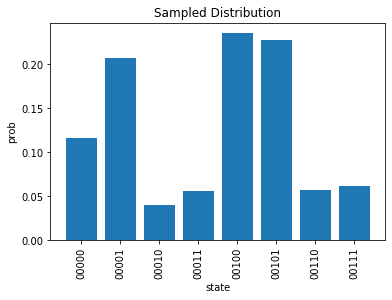

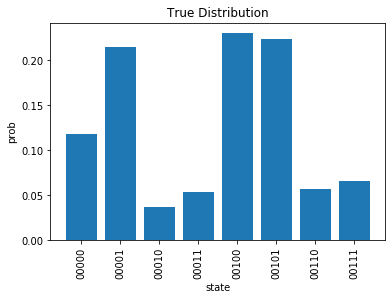

In [27]:
#convergence checking for V&V
n = 5
circ = Circuit(n)
m1 = randomStochMatrix(2)
g1 = Gate(m1,[0,1])

m2 = randomStochMatrix(1)
g2 = Gate(m2,[1])

m3 = randomStochMatrix(2)
g3 = Gate(m3,[0,2])

circ.addGate(g1)
circ.addGate(g2)
circ.addGate(g3)

print("Gates:")
print(circ)
print()

print("Wires:")
circ.printWires()

print()

print("Shot Distribution:")
dist = circ.shotsDist(10000)

distkeys = [k for k in dist]
print(distkeys)
distkeys.sort()
print(distkeys)
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k, binformat) , " => ", dist[k])

print()
print("True Distribution:")
state = circ.fullStoch()
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k,binformat), " => ", state[k])

stateHistogram(n,dist)
stateHistogram(n,state)

## Graph Example
random.seed(123)
np.random.seed(456)
print()
print("Graph Examples")
G_8 = randomConnectedGraph(8)
print("Graph (original):")
print(G_8.edges)

writeGraph(G_8,"graph_example.adjlist")
G_8_read = readGraph("graph_example.adjlist")

print("Graph (from file):")
print(G_8_read.edges)

G4 = randomConnectedGraph(4)
print("Cut Examples on Crossed Square Graph:")

vec = [1,1,1,1]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [0,0,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,1,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,-1,1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))
print()

vec = [1,-1,-1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))

##Demonstrating ansatz circuits:
g_1pbit = getAnsatzGate1bit(0, np.pi/2)
g_2pbit = getAnsatzGate2bit(0,1,gamma = 100)

print("1 pbit ansatz matrix, theta = pi/2")
print(g_1pbit.matrix)
print("2 pbit ansatz matrix, gamma = 100")
print(g_2pbit.matrix)

#Demonstrating graph embedding for K4 graph
print("K4 circuit embedding:")
k4 = randomConnectedGraph(4)
circ = getEmbeddedCircuit(k4,theta=np.pi/2, gamma=100)
circ.printWires()

#Demonstrating circuit appending
circ2 = getEmbeddedCircuit(k4,theta=0,gamma=10)
circ.appendCircuit(circ2)

print()
print()
print("Appending another circuit")
circ.printWires()

circ = getEmbeddedCircuit(k4,theta=np.pi/2, gamma=1)
expected_cut = computeCircuitCuts(circ,k4,1000)
print("expected cut: ", expected_cut)

5
Time to run 6 vertices and 5x5 grid:  14.046304818009958  seconds


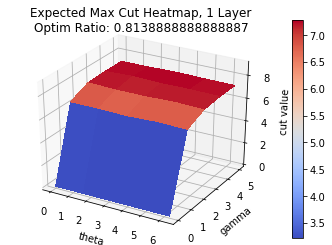

In [160]:
#plotThetaGammaHeatmap(k4)
plotgraph = randomConnectedGraph(6)
bounds = [(0,2*np.pi), (0,5)]
Ns = [5, 5];
tic = time.perf_counter()
fig = plotThetaGammaHeatmap(plotgraph,1000,bounds,Ns)
toc = time.perf_counter()

print("Time to run 6 vertices and 5x5 grid: ", toc - tic, " seconds")

fig.savefig('figures/testfig.png')

50
50
50
time to generate all 6 vertex plots:  4338.276594438998  seconds
50
50
50
time to generate all 8 vertex plots:  5988.065261335985  seconds


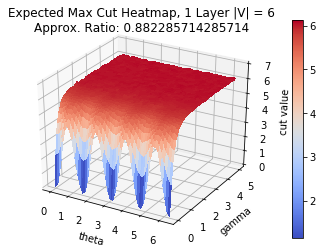

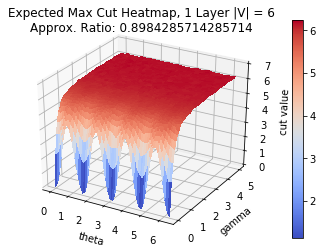

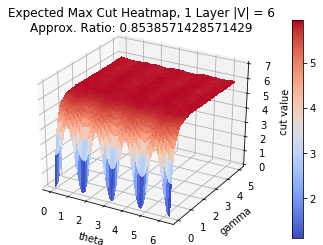

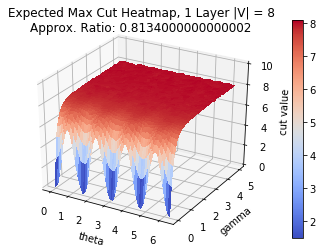

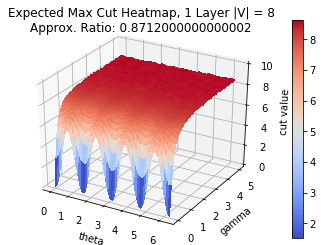

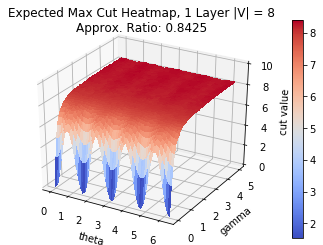

In [167]:
G6 = dict()
G8 = dict()
bounds = [(0,2*np.pi), (0,5)]#using 2pi for gamma since it saturates above ~5, and it makes a □ grid
Ns = [50,50]
numshots = 1000

##|V| == 6
tic = time.perf_counter()
for i in range(3):
    G6[i] = randomConnectedGraph(6)
    fig = plotThetaGammaHeatmap(G6[i],numshots,bounds,Ns)
    filename = 'figures/G6MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G6[i],'graphs/G6PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 6 vertex plots: ", toc - tic, " seconds")
    
    
##|V| == 8
tic = time.perf_counter()
for i in range(3):
    G8[i] = randomConnectedGraph(8)
    fig = plotThetaGammaHeatmap(G8[i],numshots,bounds,Ns)
    filename = 'figures/G8MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G8[i],'graphs/G8PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 8 vertex plots: ", toc - tic, " seconds")
    


50


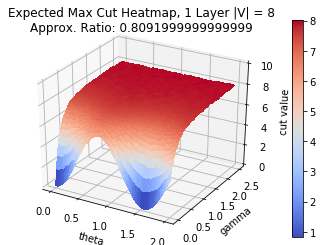

In [168]:
bounds = [(0,2), (0,2.5)]
Ns = [50,50]
numshots = 1000
fig = plotThetaGammaHeatmap(G8[0],numshots,bounds,Ns)
filename = 'figures/G8MaxCutSmallRegion.png'
fig.savefig(filename)
writeGraph(G8[i],'graphs/G8PlotGraphSmallRegion.adjlist')

In [87]:
G = randomConnectedGraph(6)
numshots = 1
bounds = [(0,6), (0.01,5)]
Ns = [2, 2]
depth = 1
opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)

theta, gamma = opt[0]
print("Best (Theta, Gamma): (", theta, ", ", gamma, ")")
print("Best Cut: ", opt[1])

theta step:  6.0
gamma step:  4.99
(slice(0, 6, 6.0), slice(0.01, 5, 4.99))
thetas:  [0.]
gammas:  [0.01]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
thetas:  [0.]
gammas:  [0.01]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.0049750

thetas:  [0.]
gammas:  [0.01005469]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
thetas:  [3.90625e-06]
gammas:  [0.0100625]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.

[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
thetas:  [7.62939453e-09]
gammas:  [0.01006245]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
thetas:  [3.05175781e-08]
gammas:  [0.01006244]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e

TypeError: cannot unpack non-iterable numpy.float64 object

time to generate all 8 vertex plots:  3420.555831359001  seconds


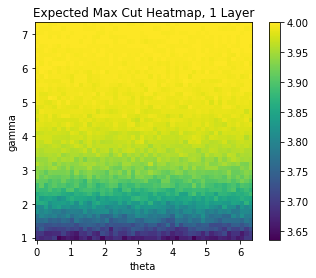

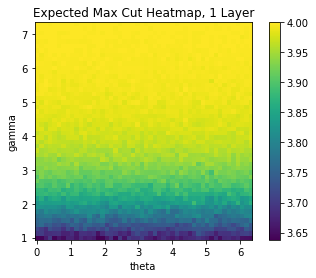

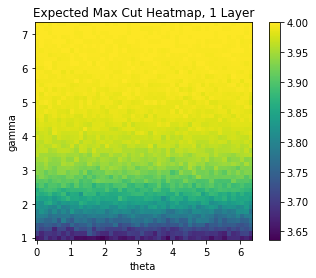

In [88]:
##|V| == 8
tic = time.perf_counter()
for i in range(3):
    G8[i] = randomConnectedGraph(8)
    fig = plotThetaGammaHeatmap(G,numshots,bounds,Ns)
    filename = 'figures/G8MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G8[i],'graphs/G8PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 8 vertex plots: ", toc - tic, " seconds")
    


In [6]:
2**3

8

In [ ]:
print(str(circ))
circ.printWires()

In [ ]:
stoch = circ.fullStoch()
for i in range(8):
    x = np.zeros((8,1))
    x[i] = 1
    a,b = np.where(np.dot(stoch,x) == 1)
    print(i , " => " , a[0])
    
print(stoch)
    

In [ ]:
np.transpose([1j])

In [ ]:
a = np.array([1,2])
b = np.array([2,4])
a + b

In [ ]:
#circ.expectationShots(100000)

In [ ]:
x = np.array([[0,1],[1,0]])
np.dot(x,x)

In [ ]:
def test_swap_alg(targs,n):
    targs = np.array(targs)
    tmpls = [i for i in range(n)]
    end = np.setdiff1d(tmpls,targs)
    ls = np.concatenate((targs,end))
    return ls

In [ ]:
print(test_swap_alg([3,1], 5))

In [ ]:
targs = [1, 3,4]
ls = [i for i in range(10)]

ls[targs in ls]

In [ ]:
hist = circ.shotsHistogram(1000)

In [ ]:
np.zeros((2,2))

In [9]:
x = np.array([[0, 1],[1,0]])
I = np.array([[1, 0],[0,1]])
np.dot(x,I)

array([[0, 1],
       [1, 0]])

True


/home/zmorrell/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


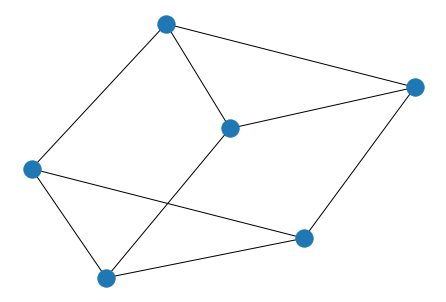

In [10]:
G = nx.generators.random_graphs.random_regular_graph(3,6)
print(nx.is_connected(G))
nx.draw(G)

In [11]:

print(G.nodes)
print(G.edges)
print(G_2.nodes)
G_2=readGraph("graph_example.adjlist")
print(G_2.edges)
sorted(G_2)

(nx.adj_matrix(G_2) - nx.adj_matrix(G)).todense()

[0, 1, 3, 4, 5, 2]
[(0, 1), (0, 5), (0, 3), (1, 3), (1, 4), (3, 2), (4, 5), (4, 2), (5, 2)]


NameError: name 'G_2' is not defined

In [12]:
sorted(G_2)

NameError: name 'G_2' is not defined

In [13]:
def myParsedGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    return G

In [14]:
G_mine = myParsedGraph("graph_example.adjlist")

In [15]:
G_mine.edges()

EdgeView([(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)])

In [16]:
vec = np.array([[1, 0]])
mat = np.array([[1,1],[0,1]])

print(vec)
print((np.transpose(vec)))
print(mat)
print(np.matmul(mat,vec.T))
print(np.matmul(vec,np.matmul(mat,vec.T)))

[[1 0]]
[[1]
 [0]]
[[1 1]
 [0 1]]
[[1]
 [0]]
[[1]]


In [56]:
x = np.linspace(1,10,10)
y = np.linspace(1,15,15)
X, Y = np.meshgrid(x,y)
print(X,Y)

Z = X*Y
print(Z)
print(np.amax(Z))

[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]] [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 9.  9. 

In [18]:
graphCutBin(G,[1, 0, 1, 0,1,0,1,0])

ValueError: dimension mismatch

In [19]:
vec = np.array([[1,-1,1,-1,1,-1]])
mat = graphMatrix(G)

In [150]:
"""
def misra_gries(G):
    #assumes that it is operating on a 3-reg graph => Needs at most 4 colors with misra gries
    #use 0 to imply edge is uncolored
    #1-4 indicate the coloring of each edge
    #God help you if you have to debug this
    colors = ["-1", "0", "1", "2", "3"] #list of possible colors; -1 => uncolored
    vertices = G.nodes
    edges = G.edges
    edge_colors = dict()
    for edge in edges():
        edge_colors[edge] = colors[0]
    free_colors = dict()
    for vertex in vertices():
        free_colors[vertex] = colors[-4:]
        
    U = list(G.edges)
    
    for u,v in U:
        #start by creating a maximal fan
        print(edge_colors)
        print("(",u,",",v,")")
        if edge_colors[(u,v)] != "-1":
            continue
        F = []
        F.append(v)
        rem_edges = list(edges(u))
        rem_edges.remove((u,v))
        counter = 0;
        for _,b in rem_edges:
            if edge_colors[tuple(sorted((u,b)))] in free_colors[F[-1]] or edge_colors[tuple(sorted((u,b)))] == "-1":
                F.append(b)
            else:
                rem_edges.append(u,b);
            counter += 1
            if counter > 100:
                print("COUNTER EXCEEDED 100 ITERATIONS, MAY BE IN INFINITE LOOP")
                return
        print(F)
        
        #Maximal Fan has been constructed
        #Now need to invert cd_u path
        c = free_colors[u][0]
        d = free_colors[F[-1]][0]
        swap_color = c
        path_color = d
        u_prime = None
        v_prime = u
        path = [u]
        print("C: ", c, ", D: ", d)
        if(c != d):
            #constructing a cd_u path to invert
            while(True):
                u_prime = v_prime
                v_prime = None
                
                for edge in edges(u_prime):
                    print(edge_colors[tuple(sorted(edge))] == path_color)
                    if(edge_colors[tuple(sorted(edge))] == path_color):
                        if (edge[0] == u_prime):
                            v_prime = edge[1]
                        else:
                            v_prime = edge[0]
                        if path_color == c:
                            path_color = d
                        else:
                            path_color = c;
                        path.append(v_prime)
                        break
            
                if v_prime == None:
                    break
            #inverting the cd_u path
            while(len(path) > 1):
                edge_colors[tuple(sorted(path[:2]))] = swap_color
                free_colors[path[0]].remove(swap_color)
                free_colors[path[1]].remove(swap_color)
                if swap_color == c:
                    swap_color = d
                else:
                    swap_color = c
                free_colors[path[0]].append(swap_color)
                free_colors[path[0]].sort()
                free_colors[path[1]].append(swap_color)
                free_colors[path[1]].sort()
                path.pop(0)
        
        w = None
        #Find first w s.t. color d is free on w, and rotate that sub-fan.
        for w in range(1,len(F)+1):
            if(d in free_colors[F[w]]):
                break
        F_prime = F[:w+1]
        #rotate subfan
        for i in range(w+1):
            if(edge_colors[tuple(sorted((u,F[i])))] != "-1"):
                free_colors[F[i]].append(edge_colors[tuple(sorted((u,F[i])))])
                free_colors[F[i]].sort()
            print("line 98?")
            if(i != w and edge_colors[tuple(sorted((u,F[i+1])))] != "-1"):
                free_colors[F[i]].remove(edge_colors[tuple(sorted((u,F[i+1])))])
            if(i == w):
                edge_colors[tuple(sorted((u,F[i])))] = d
                free_colors[u].remove(d)
            else:
                edge_colors[tuple(sorted((u,F[i])))] = edge_colors[tuple(sorted((u,F[i+1])))]
        U.remove(tuple(sorted((u,F[w]))))
        if edge_colors[(u,v)] == "-1":
            U.append((u,v))
        #print(edge_colors)
    return edge_colors
"""


"""From Wikipedia:
    algorithm Misra & Gries edge coloring algorithm is
    input: A graph G.
    output: A proper coloring c of the edges of G.

    Let U := E(G)

    while U ≠ ∅ do
        Let (u, v) be any edge in U.  
        Let F[1:k] be a maximal fan of u starting at F[1] = v.
        Let c be a color that is free on u and d be a color that is free on F[k].  
        Invert the cdu path  
        Let w ∈ V(G) be such that w ∈ F, F' = [F[1]...w] is a fan and d is free on w.  
        Rotate F' and set c(u, w) = d.
        U := U − {(u, v)}
    end while
"""

"From Wikipedia:\n    algorithm Misra & Gries edge coloring algorithm is\n    input: A graph G.\n    output: A proper coloring c of the edges of G.\n\n    Let U := E(G)\n\n    while U ≠ ∅ do\n        Let (u, v) be any edge in U.  \n        Let F[1:k] be a maximal fan of u starting at F[1] = v.\n        Let c be a color that is free on u and d be a color that is free on F[k].  \n        Invert the cdu path  \n        Let w ∈ V(G) be such that w ∈ F, F' = [F[1]...w] is a fan and d is free on w.  \n        Rotate F' and set c(u, w) = d.\n        U := U − {(u, v)}\n    end while\n"

In [152]:
"""G = randomConnectedGraph(4)
edge_colors = misra_gries(G)
print(edge_colors)"""

'G = randomConnectedGraph(4)\nedge_colors = misra_gries(G)\nprint(edge_colors)'

In [ ]:
ls = [0]
for i in ls:
    ls.append(i+1)
    print(i)
    if i >10:
        break


In [ ]:
(1,2).remove(1)

In [ ]:
sorted((2,1))

In [ ]:
tempdict = {}
tempdict[(1,2)] = "yay"
tempdict[tuple(sorted([2,1]))]

In [ ]:
ls = [1,2,3]
ls.pop(0)
print(ls)

In [ ]:
ls = [(1,2), (3,4)]
ls.append((5,6))
print(ls)

In [ ]:
qwerty = None
for qwerty in [1,2,3,4,5]:
    if qwerty == 3:
        break
print(qwerty)

In [ ]:
lsdict = dict()
lsdict[1] = [1,2]
lsdict[1].append(3)
lsdict[1].sort()
print(lsdict[1])

In [42]:
max_color = 0
min_color = 100
for i in range(1000):
    G = randomConnectedGraph(100)
    lg = nx.generators.line.line_graph(G)
    colors = nx.coloring.equitable_color(lg,num_colors=4)
    for k in colors.keys():
        if colors[k] > max_color:
            max_color = colors[k]
        if colors[k] < min_color:
            min_color = colors[k]


print(max_color)
print(min_color)

NetworkXAlgorithmError: Graph has maximum degree 4, needs 5 (> 4) colors for guaranteed coloring.

In [ ]:
arr = [1,2,3,4]
print(arr[:2])
print(arr[2:])

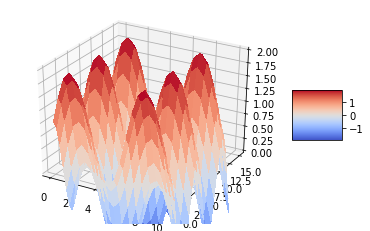

In [151]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def surfacePlotTest():
    xs = np.linspace(0,10,20)
    ys = np.linspace(0,15,30)
    
    X, Y = np.meshgrid(xs,ys)
    Z = np.sin(X) + np.cos(Y)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, \
                       linewidth=0, antialiased=False)
    
    ax.set_zlim(0, 2)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    #ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=1)
    return fig

fig = surfacePlotTest()


In [84]:
for x in slice(.5,10.5,1.5):
    print(x)

TypeError: 'slice' object is not iterable